## Test on a simple case
Consider the following Poisson Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u = xy\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|\ 0< x, y< 1\}$

The exact solution to this problem is $$u = xy.$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        torch.nn.init.constant_(self.linear5.bias, 0.)
        torch.nn.init.constant_(self.linear6.bias, 0.)
        torch.nn.init.constant_(self.linear7.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear5.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear6.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear7.weight, mean=0, std=0.1)
        
        
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        #y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def cal_loss(mod):
    points = np.arange(0, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            mmm += abs(z[i, j])
            t += 1
    return mmm / t

In [3]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            w[i, j] = U_groundtruth(re)
            t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [4]:
#U_groundtruth = x * y
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    return (t[0] * t[1]).item()

In [5]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [14]:
def draw_graph(mod):
    points = np.arange(0, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    my_x_ticks = np.arange(0, 1, 0.2)
    my_y_ticks = np.arange(0, 1, 0.2)
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,99,5))  
    ax.set_xticklabels(('0', '0.25', '0.5', '0.75', '1'))  
    ax.set_yticks(np.linspace(0,99,5))  
    ax.set_yticklabels( ('1', '0.75', '0.5', '0.25', '0'))  
    
    #plt.savefig("../Adaptive/loss_1.eps")
    
    plt.savefig("loss_yubing_2blocks.eps")
    plt.show()

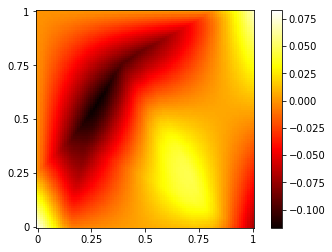

0.02921018591104461


In [15]:
validate(model)

In [11]:
relative_err(model)

0.01982772920459404

In [36]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [10]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
model = DeepRitzNet(m)
model.load_state_dict(torch.load(PATH))

In [33]:
model = DeepRitzNet(m)

In [34]:
#训练the_model
train(model, opt='Adam', iterations=50000, milestones=[10000,20000,30000,40000], gamma=0.5, beta=1, 
      beta_increase=1.01, alpha=0, alpha_increase=1, initial_lr=0.00001, print_every_iter=5)

4  epoch, loss:  0.03819517
4  epoch, regularization loss:  0.06121579
4  loss to real solution:  0.12841014121312747
9  epoch, loss:  0.038181126
9  epoch, regularization loss:  0.07221659
9  loss to real solution:  0.1284049067184453
14  epoch, loss:  0.038173772
14  epoch, regularization loss:  0.07051422
14  loss to real solution:  0.1283965558337033
19  epoch, loss:  0.038169798
19  epoch, regularization loss:  0.0799896
19  loss to real solution:  0.12838766931533083
24  epoch, loss:  0.03816153
24  epoch, regularization loss:  0.090353094
24  loss to real solution:  0.12838160946872862
29  epoch, loss:  0.038162682
29  epoch, regularization loss:  0.06915074
29  loss to real solution:  0.1283716952320466
34  epoch, loss:  0.038155872
34  epoch, regularization loss:  0.061638094
34  loss to real solution:  0.12836206292441074
39  epoch, loss:  0.03815755
39  epoch, regularization loss:  0.09666337
39  loss to real solution:  0.12835010101726238
44  epoch, loss:  0.03815173
44  ep

339  epoch, loss:  0.040729202
339  epoch, regularization loss:  1.495873
339  loss to real solution:  0.1256672692483615
344  epoch, loss:  0.040792257
344  epoch, regularization loss:  1.9549611
344  loss to real solution:  0.12560726344215975
349  epoch, loss:  0.040876802
349  epoch, regularization loss:  1.4763802
349  loss to real solution:  0.12554568453207002
354  epoch, loss:  0.04092191
354  epoch, regularization loss:  1.5427364
354  loss to real solution:  0.12548365447701015
359  epoch, loss:  0.04099533
359  epoch, regularization loss:  1.7625996
359  loss to real solution:  0.1254232003121091
364  epoch, loss:  0.041051067
364  epoch, regularization loss:  2.1373022
364  loss to real solution:  0.12536293867698392
369  epoch, loss:  0.041132275
369  epoch, regularization loss:  1.9993913
369  loss to real solution:  0.1253007257286429
374  epoch, loss:  0.041228686
374  epoch, regularization loss:  2.5796905
374  loss to real solution:  0.12523388352984
379  epoch, loss:

674  epoch, loss:  0.046793364
674  epoch, regularization loss:  25.771862
674  loss to real solution:  0.12199551252155641
679  epoch, loss:  0.046871733
679  epoch, regularization loss:  20.17377
679  loss to real solution:  0.12197020540460335
684  epoch, loss:  0.046956476
684  epoch, regularization loss:  36.384346
684  loss to real solution:  0.12194520932629957
689  epoch, loss:  0.047035683
689  epoch, regularization loss:  26.394093
689  loss to real solution:  0.12192177221271377
694  epoch, loss:  0.04707512
694  epoch, regularization loss:  27.193367
694  loss to real solution:  0.12189806402160615
699  epoch, loss:  0.047170922
699  epoch, regularization loss:  26.918522
699  loss to real solution:  0.12188160027046348
704  epoch, loss:  0.047246672
704  epoch, regularization loss:  21.51187
704  loss to real solution:  0.1218647359736449
709  epoch, loss:  0.047312055
709  epoch, regularization loss:  24.501442
709  loss to real solution:  0.12184479435613338
714  epoch, 

1009  epoch, loss:  0.050747894
1009  epoch, regularization loss:  23.869865
1009  loss to real solution:  0.12090104437317735
1014  epoch, loss:  0.050784696
1014  epoch, regularization loss:  22.583084
1014  loss to real solution:  0.12088389376778745
1019  epoch, loss:  0.050827097
1019  epoch, regularization loss:  21.115438
1019  loss to real solution:  0.12086199264757895
1024  epoch, loss:  0.050882645
1024  epoch, regularization loss:  16.4418
1024  loss to real solution:  0.12084233203548789
1029  epoch, loss:  0.050896015
1029  epoch, regularization loss:  20.457016
1029  loss to real solution:  0.12082669883165975
1034  epoch, loss:  0.050944485
1034  epoch, regularization loss:  23.832844
1034  loss to real solution:  0.12081192426876101
1039  epoch, loss:  0.050979067
1039  epoch, regularization loss:  22.667746
1039  loss to real solution:  0.1207970910556307
1044  epoch, loss:  0.05103897
1044  epoch, regularization loss:  27.185097
1044  loss to real solution:  0.120783

1334  epoch, loss:  0.053924154
1334  epoch, regularization loss:  23.635586
1334  loss to real solution:  0.12012676611050106
1339  epoch, loss:  0.053965285
1339  epoch, regularization loss:  26.43619
1339  loss to real solution:  0.12011783631256794
1344  epoch, loss:  0.054004602
1344  epoch, regularization loss:  29.505997
1344  loss to real solution:  0.12010730456283768
1349  epoch, loss:  0.05404542
1349  epoch, regularization loss:  23.294144
1349  loss to real solution:  0.1201024010839049
1354  epoch, loss:  0.054104544
1354  epoch, regularization loss:  19.908379
1354  loss to real solution:  0.12009472324520601
1359  epoch, loss:  0.054150544
1359  epoch, regularization loss:  19.890572
1359  loss to real solution:  0.12008309823052947
1364  epoch, loss:  0.054194983
1364  epoch, regularization loss:  23.84005
1364  loss to real solution:  0.12006543159546443
1369  epoch, loss:  0.054241613
1369  epoch, regularization loss:  24.975323
1369  loss to real solution:  0.120053

1659  epoch, loss:  0.05685382
1659  epoch, regularization loss:  21.33853
1659  loss to real solution:  0.11943765543770697
1664  epoch, loss:  0.056892943
1664  epoch, regularization loss:  18.235435
1664  loss to real solution:  0.11943499685811608
1669  epoch, loss:  0.056957256
1669  epoch, regularization loss:  22.644466
1669  loss to real solution:  0.11942699105532707
1674  epoch, loss:  0.056982037
1674  epoch, regularization loss:  19.769695
1674  loss to real solution:  0.11942072268483073
1679  epoch, loss:  0.057042502
1679  epoch, regularization loss:  20.501892
1679  loss to real solution:  0.1194075457634759
1684  epoch, loss:  0.05706407
1684  epoch, regularization loss:  19.446281
1684  loss to real solution:  0.11939026874451604
1689  epoch, loss:  0.057160858
1689  epoch, regularization loss:  20.089945
1689  loss to real solution:  0.11937272296587303
1694  epoch, loss:  0.05722002
1694  epoch, regularization loss:  18.40332
1694  loss to real solution:  0.11934867

1984  epoch, loss:  0.059886716
1984  epoch, regularization loss:  22.398962
1984  loss to real solution:  0.11855183417208436
1989  epoch, loss:  0.059940513
1989  epoch, regularization loss:  24.953773
1989  loss to real solution:  0.11853551636919507
1994  epoch, loss:  0.05999613
1994  epoch, regularization loss:  23.285898
1994  loss to real solution:  0.11852711697871039
1999  epoch, loss:  0.060048837
1999  epoch, regularization loss:  20.531012
1999  loss to real solution:  0.11851720216476232
2004  epoch, loss:  0.06009018
2004  epoch, regularization loss:  18.614492
2004  loss to real solution:  0.11851166527502797
2009  epoch, loss:  0.060133334
2009  epoch, regularization loss:  21.611286
2009  loss to real solution:  0.11850159215163597
2014  epoch, loss:  0.06016713
2014  epoch, regularization loss:  20.646467
2014  loss to real solution:  0.11848044875855293
2019  epoch, loss:  0.06019521
2019  epoch, regularization loss:  21.527617
2019  loss to real solution:  0.118449

2309  epoch, loss:  0.063023336
2309  epoch, regularization loss:  20.62767
2309  loss to real solution:  0.11742765692085771
2314  epoch, loss:  0.063124344
2314  epoch, regularization loss:  19.55826
2314  loss to real solution:  0.11742242581280307
2319  epoch, loss:  0.06314505
2319  epoch, regularization loss:  17.802065
2319  loss to real solution:  0.11740560463391064
2324  epoch, loss:  0.0631792
2324  epoch, regularization loss:  25.649036
2324  loss to real solution:  0.11737679335881368
2329  epoch, loss:  0.0632423
2329  epoch, regularization loss:  19.582571
2329  loss to real solution:  0.11734748489908448
2334  epoch, loss:  0.06327774
2334  epoch, regularization loss:  20.702282
2334  loss to real solution:  0.11730967320255509
2339  epoch, loss:  0.06328804
2339  epoch, regularization loss:  20.784422
2339  loss to real solution:  0.11726823555167061
2344  epoch, loss:  0.06334128
2344  epoch, regularization loss:  18.918486
2344  loss to real solution:  0.117224978712

2639  epoch, loss:  0.066351324
2639  epoch, regularization loss:  20.195066
2639  loss to real solution:  0.11595130873366825
2644  epoch, loss:  0.0664235
2644  epoch, regularization loss:  16.90025
2644  loss to real solution:  0.1159284957255091
2649  epoch, loss:  0.06647311
2649  epoch, regularization loss:  17.33724
2649  loss to real solution:  0.11589521782272615
2654  epoch, loss:  0.06652579
2654  epoch, regularization loss:  16.821306
2654  loss to real solution:  0.11586383362200639
2659  epoch, loss:  0.066555545
2659  epoch, regularization loss:  19.05395
2659  loss to real solution:  0.11583019341165128
2664  epoch, loss:  0.06654527
2664  epoch, regularization loss:  17.403511
2664  loss to real solution:  0.11579123065429782
2669  epoch, loss:  0.06659512
2669  epoch, regularization loss:  19.365196
2669  loss to real solution:  0.11574624456434461
2674  epoch, loss:  0.066643484
2674  epoch, regularization loss:  19.363012
2674  loss to real solution:  0.115709084470

2969  epoch, loss:  0.06982648
2969  epoch, regularization loss:  16.542017
2969  loss to real solution:  0.11445351041915007
2974  epoch, loss:  0.0699004
2974  epoch, regularization loss:  20.685175
2974  loss to real solution:  0.11443003988185949
2979  epoch, loss:  0.069935
2979  epoch, regularization loss:  21.011835
2979  loss to real solution:  0.11441564205818437
2984  epoch, loss:  0.07003364
2984  epoch, regularization loss:  18.96753
2984  loss to real solution:  0.11439546631695323
2989  epoch, loss:  0.07003727
2989  epoch, regularization loss:  20.0767
2989  loss to real solution:  0.11437310660119396
2994  epoch, loss:  0.07012471
2994  epoch, regularization loss:  17.909678
2994  loss to real solution:  0.11434753366861466
2999  epoch, loss:  0.07019222
2999  epoch, regularization loss:  22.41393
2999  loss to real solution:  0.11433327444267179
3004  epoch, loss:  0.0702529
3004  epoch, regularization loss:  16.08907
3004  loss to real solution:  0.11432152238328107
3

3299  epoch, loss:  0.07386794
3299  epoch, regularization loss:  17.767609
3299  loss to real solution:  0.11289624256181945
3304  epoch, loss:  0.073965594
3304  epoch, regularization loss:  18.513502
3304  loss to real solution:  0.11288649084477514
3309  epoch, loss:  0.07405875
3309  epoch, regularization loss:  17.026104
3309  loss to real solution:  0.11286692207186558
3314  epoch, loss:  0.074064806
3314  epoch, regularization loss:  23.024942
3314  loss to real solution:  0.11283469278057504
3319  epoch, loss:  0.07411626
3319  epoch, regularization loss:  16.945295
3319  loss to real solution:  0.1128098038197611
3324  epoch, loss:  0.07418328
3324  epoch, regularization loss:  17.222212
3324  loss to real solution:  0.11278932930870865
3329  epoch, loss:  0.074223205
3329  epoch, regularization loss:  19.293
3329  loss to real solution:  0.11275916542149778
3334  epoch, loss:  0.07428805
3334  epoch, regularization loss:  17.261557
3334  loss to real solution:  0.11272106580

3624  epoch, loss:  0.07764825
3624  epoch, regularization loss:  19.977018
3624  loss to real solution:  0.11085001995956362
3629  epoch, loss:  0.07771064
3629  epoch, regularization loss:  14.391916
3629  loss to real solution:  0.11081753205885146
3634  epoch, loss:  0.077771336
3634  epoch, regularization loss:  18.380877
3634  loss to real solution:  0.11078413690178668
3639  epoch, loss:  0.07782243
3639  epoch, regularization loss:  18.246725
3639  loss to real solution:  0.11074137183337301
3644  epoch, loss:  0.07723486
3644  epoch, regularization loss:  16.093723
3644  loss to real solution:  0.11068391810887122
3649  epoch, loss:  0.07727487
3649  epoch, regularization loss:  16.590893
3649  loss to real solution:  0.11063459889824731
3654  epoch, loss:  0.07736767
3654  epoch, regularization loss:  19.863836
3654  loss to real solution:  0.11059475290073349
3659  epoch, loss:  0.07741258
3659  epoch, regularization loss:  18.671537
3659  loss to real solution:  0.110565188

3954  epoch, loss:  0.08120274
3954  epoch, regularization loss:  17.320087
3954  loss to real solution:  0.10860041923205227
3959  epoch, loss:  0.08129717
3959  epoch, regularization loss:  17.520271
3959  loss to real solution:  0.10854548851813173
3964  epoch, loss:  0.08136331
3964  epoch, regularization loss:  20.662773
3964  loss to real solution:  0.1085020011571075
3969  epoch, loss:  0.081514224
3969  epoch, regularization loss:  17.886616
3969  loss to real solution:  0.10848462209290223
3974  epoch, loss:  0.08156258
3974  epoch, regularization loss:  14.808119
3974  loss to real solution:  0.10845167525605234
3979  epoch, loss:  0.08161881
3979  epoch, regularization loss:  18.35949
3979  loss to real solution:  0.10840387236173
3984  epoch, loss:  0.08152576
3984  epoch, regularization loss:  16.07487
3984  loss to real solution:  0.10835047123353349
3989  epoch, loss:  0.0815241
3989  epoch, regularization loss:  13.911541
3989  loss to real solution:  0.1083001656984249

4284  epoch, loss:  0.08572551
4284  epoch, regularization loss:  16.675724
4284  loss to real solution:  0.10650768641228524
4289  epoch, loss:  0.08578552
4289  epoch, regularization loss:  14.472267
4289  loss to real solution:  0.10646978025963488
4294  epoch, loss:  0.0857795
4294  epoch, regularization loss:  11.57335
4294  loss to real solution:  0.10641945466645499
4299  epoch, loss:  0.08576543
4299  epoch, regularization loss:  13.832859
4299  loss to real solution:  0.1063627276698913
4304  epoch, loss:  0.08583396
4304  epoch, regularization loss:  15.930127
4304  loss to real solution:  0.10631568909122437
4309  epoch, loss:  0.08591372
4309  epoch, regularization loss:  17.499424
4309  loss to real solution:  0.10627553193960806
4314  epoch, loss:  0.0859517
4314  epoch, regularization loss:  16.067427
4314  loss to real solution:  0.10623593151877248
4319  epoch, loss:  0.08604728
4319  epoch, regularization loss:  17.863602
4319  loss to real solution:  0.10620027026146

4614  epoch, loss:  0.09053909
4614  epoch, regularization loss:  14.279588
4614  loss to real solution:  0.10434928574037458
4619  epoch, loss:  0.09055927
4619  epoch, regularization loss:  16.818726
4619  loss to real solution:  0.104308689266197
4624  epoch, loss:  0.090588205
4624  epoch, regularization loss:  15.822136
4624  loss to real solution:  0.1042663869015442
4629  epoch, loss:  0.090641744
4629  epoch, regularization loss:  18.069942
4629  loss to real solution:  0.10424668029135421
4634  epoch, loss:  0.090761185
4634  epoch, regularization loss:  13.374568
4634  loss to real solution:  0.10422538473093809
4639  epoch, loss:  0.09079538
4639  epoch, regularization loss:  17.111364
4639  loss to real solution:  0.10418999284136399
4644  epoch, loss:  0.0908895
4644  epoch, regularization loss:  14.646698
4644  loss to real solution:  0.10415668676030049
4649  epoch, loss:  0.09098281
4649  epoch, regularization loss:  12.733409
4649  loss to real solution:  0.10412530540

4944  epoch, loss:  0.095541805
4944  epoch, regularization loss:  17.7047
4944  loss to real solution:  0.10210632141741105
4949  epoch, loss:  0.09562005
4949  epoch, regularization loss:  11.927082
4949  loss to real solution:  0.10207251298402957
4954  epoch, loss:  0.09568415
4954  epoch, regularization loss:  15.873495
4954  loss to real solution:  0.10202111887907199
4959  epoch, loss:  0.09572817
4959  epoch, regularization loss:  15.931625
4959  loss to real solution:  0.10198049668191883
4964  epoch, loss:  0.095795415
4964  epoch, regularization loss:  16.468962
4964  loss to real solution:  0.1019296282970093
4969  epoch, loss:  0.095874675
4969  epoch, regularization loss:  15.363834
4969  loss to real solution:  0.10189241310104363
4974  epoch, loss:  0.09596052
4974  epoch, regularization loss:  11.983595
4974  loss to real solution:  0.10184362659153864
4979  epoch, loss:  0.09604055
4979  epoch, regularization loss:  16.883669
4979  loss to real solution:  0.1018050119

5274  epoch, loss:  0.10025297
5274  epoch, regularization loss:  16.76999
5274  loss to real solution:  0.09993760844492473
5279  epoch, loss:  0.100322135
5279  epoch, regularization loss:  14.666715
5279  loss to real solution:  0.09988805264757934
5284  epoch, loss:  0.10041936
5284  epoch, regularization loss:  13.91551
5284  loss to real solution:  0.09983342876211429
5289  epoch, loss:  0.100455396
5289  epoch, regularization loss:  12.867167
5289  loss to real solution:  0.09977865492601783
5294  epoch, loss:  0.10052399
5294  epoch, regularization loss:  11.878423
5294  loss to real solution:  0.09971509672455063
5299  epoch, loss:  0.100607425
5299  epoch, regularization loss:  13.558734
5299  loss to real solution:  0.09967066810427869
5304  epoch, loss:  0.100699894
5304  epoch, regularization loss:  16.083183
5304  loss to real solution:  0.09963774855287119
5309  epoch, loss:  0.100788325
5309  epoch, regularization loss:  18.044498
5309  loss to real solution:  0.0996105

5599  epoch, loss:  0.104861535
5599  epoch, regularization loss:  15.126296
5599  loss to real solution:  0.09767723548018246
5604  epoch, loss:  0.10494447
5604  epoch, regularization loss:  11.793387
5604  loss to real solution:  0.09763231603751994
5609  epoch, loss:  0.10496211
5609  epoch, regularization loss:  13.208964
5609  loss to real solution:  0.09757619809513253
5614  epoch, loss:  0.1050746
5614  epoch, regularization loss:  12.051562
5614  loss to real solution:  0.09755103677634369
5619  epoch, loss:  0.10515206
5619  epoch, regularization loss:  12.350362
5619  loss to real solution:  0.0975405473286702
5624  epoch, loss:  0.10525798
5624  epoch, regularization loss:  12.545996
5624  loss to real solution:  0.09749399930300302
5629  epoch, loss:  0.10532118
5629  epoch, regularization loss:  14.62324
5629  loss to real solution:  0.09741055537107565
5634  epoch, loss:  0.10540213
5634  epoch, regularization loss:  14.569225
5634  loss to real solution:  0.097341090806

5929  epoch, loss:  0.10994672
5929  epoch, regularization loss:  11.811226
5929  loss to real solution:  0.09490903392680423
5934  epoch, loss:  0.110039786
5934  epoch, regularization loss:  13.124326
5934  loss to real solution:  0.09487685260632317
5939  epoch, loss:  0.11013153
5939  epoch, regularization loss:  14.66596
5939  loss to real solution:  0.09484508994997536
5944  epoch, loss:  0.1102564
5944  epoch, regularization loss:  13.332759
5944  loss to real solution:  0.09481234132319938
5949  epoch, loss:  0.11034774
5949  epoch, regularization loss:  11.079114
5949  loss to real solution:  0.09477184971132557
5954  epoch, loss:  0.1104323
5954  epoch, regularization loss:  12.665604
5954  loss to real solution:  0.0947367308301128
5959  epoch, loss:  0.110472195
5959  epoch, regularization loss:  15.159851
5959  loss to real solution:  0.09470776321905214
5964  epoch, loss:  0.110640466
5964  epoch, regularization loss:  11.549471
5964  loss to real solution:  0.09469961799

6254  epoch, loss:  0.116150916
6254  epoch, regularization loss:  11.8956375
6254  loss to real solution:  0.09278431453426518
6259  epoch, loss:  0.11623905
6259  epoch, regularization loss:  12.859193
6259  loss to real solution:  0.0927530641053334
6264  epoch, loss:  0.11633639
6264  epoch, regularization loss:  11.159477
6264  loss to real solution:  0.09270043876114466
6269  epoch, loss:  0.11642527
6269  epoch, regularization loss:  14.263561
6269  loss to real solution:  0.09265227736150926
6274  epoch, loss:  0.11650368
6274  epoch, regularization loss:  12.096316
6274  loss to real solution:  0.09261048229826879
6279  epoch, loss:  0.116494656
6279  epoch, regularization loss:  12.093676
6279  loss to real solution:  0.09256452462335758
6284  epoch, loss:  0.11666333
6284  epoch, regularization loss:  12.489006
6284  loss to real solution:  0.09250801012227854
6289  epoch, loss:  0.11675916
6289  epoch, regularization loss:  14.004905
6289  loss to real solution:  0.09246664

6579  epoch, loss:  0.12205072
6579  epoch, regularization loss:  11.104541
6579  loss to real solution:  0.09025832546397676
6584  epoch, loss:  0.12217147
6584  epoch, regularization loss:  11.305633
6584  loss to real solution:  0.09023302520109605
6589  epoch, loss:  0.12224903
6589  epoch, regularization loss:  12.364922
6589  loss to real solution:  0.0901827512078049
6594  epoch, loss:  0.122301005
6594  epoch, regularization loss:  11.955243
6594  loss to real solution:  0.0901568939986308
6599  epoch, loss:  0.12242766
6599  epoch, regularization loss:  11.267256
6599  loss to real solution:  0.09012198859810339
6604  epoch, loss:  0.12241428
6604  epoch, regularization loss:  9.856133
6604  loss to real solution:  0.0900865458783286
6609  epoch, loss:  0.12246224
6609  epoch, regularization loss:  12.010302
6609  loss to real solution:  0.09004430496557195
6614  epoch, loss:  0.122629344
6614  epoch, regularization loss:  11.284261
6614  loss to real solution:  0.089993918397

6909  epoch, loss:  0.12782267
6909  epoch, regularization loss:  10.174494
6909  loss to real solution:  0.08759625742196546
6914  epoch, loss:  0.12792276
6914  epoch, regularization loss:  10.687148
6914  loss to real solution:  0.08754568539005668
6919  epoch, loss:  0.12799145
6919  epoch, regularization loss:  9.849565
6919  loss to real solution:  0.08747822018263261
6924  epoch, loss:  0.12808071
6924  epoch, regularization loss:  9.72188
6924  loss to real solution:  0.08740884597944328
6929  epoch, loss:  0.12814155
6929  epoch, regularization loss:  11.186077
6929  loss to real solution:  0.08732553155523194
6934  epoch, loss:  0.12826464
6934  epoch, regularization loss:  11.41575
6934  loss to real solution:  0.08726586084966818
6939  epoch, loss:  0.128378
6939  epoch, regularization loss:  9.503419
6939  loss to real solution:  0.08722104181127607
6944  epoch, loss:  0.12839125
6944  epoch, regularization loss:  11.925021
6944  loss to real solution:  0.08715945929904614

7239  epoch, loss:  0.13305728
7239  epoch, regularization loss:  11.184722
7239  loss to real solution:  0.08433411713412477
7244  epoch, loss:  0.13312314
7244  epoch, regularization loss:  9.214372
7244  loss to real solution:  0.0843003805819129
7249  epoch, loss:  0.13320628
7249  epoch, regularization loss:  11.443561
7249  loss to real solution:  0.08423504254603682
7254  epoch, loss:  0.13331358
7254  epoch, regularization loss:  12.563472
7254  loss to real solution:  0.08417454692573587
7259  epoch, loss:  0.13340785
7259  epoch, regularization loss:  13.372754
7259  loss to real solution:  0.08412780618556767
7264  epoch, loss:  0.13357149
7264  epoch, regularization loss:  11.731755
7264  loss to real solution:  0.08408688792019836
7269  epoch, loss:  0.13364768
7269  epoch, regularization loss:  12.387163
7269  loss to real solution:  0.08405675227669153
7274  epoch, loss:  0.13367505
7274  epoch, regularization loss:  10.079933
7274  loss to real solution:  0.084025031029

7569  epoch, loss:  0.13834086
7569  epoch, regularization loss:  11.126174
7569  loss to real solution:  0.08106091778140422
7574  epoch, loss:  0.13850023
7574  epoch, regularization loss:  10.066678
7574  loss to real solution:  0.08100457661408038
7579  epoch, loss:  0.13858402
7579  epoch, regularization loss:  8.459224
7579  loss to real solution:  0.08093429420974628
7584  epoch, loss:  0.13867031
7584  epoch, regularization loss:  11.069052
7584  loss to real solution:  0.08087368262823948
7589  epoch, loss:  0.13876204
7589  epoch, regularization loss:  9.640374
7589  loss to real solution:  0.0808108609335974
7594  epoch, loss:  0.13865782
7594  epoch, regularization loss:  10.300834
7594  loss to real solution:  0.08074570031082334
7599  epoch, loss:  0.13875154
7599  epoch, regularization loss:  9.946538
7599  loss to real solution:  0.08067183423879717
7604  epoch, loss:  0.13881321
7604  epoch, regularization loss:  11.887878
7604  loss to real solution:  0.08060027233578

7899  epoch, loss:  0.1449691
7899  epoch, regularization loss:  9.65198
7899  loss to real solution:  0.07762804639240926
7904  epoch, loss:  0.14509094
7904  epoch, regularization loss:  8.679935
7904  loss to real solution:  0.07754588539196439
7909  epoch, loss:  0.14516914
7909  epoch, regularization loss:  10.202368
7909  loss to real solution:  0.07750068016411843
7914  epoch, loss:  0.14532919
7914  epoch, regularization loss:  9.647823
7914  loss to real solution:  0.07745652365167278
7919  epoch, loss:  0.14519401
7919  epoch, regularization loss:  10.22563
7919  loss to real solution:  0.07737141776306569
7924  epoch, loss:  0.14532325
7924  epoch, regularization loss:  8.010519
7924  loss to real solution:  0.07730261282117898
7929  epoch, loss:  0.1454044
7929  epoch, regularization loss:  8.419491
7929  loss to real solution:  0.07722929104177419
7934  epoch, loss:  0.14547633
7934  epoch, regularization loss:  11.341182
7934  loss to real solution:  0.07713833343022125
7

8229  epoch, loss:  0.15101503
8229  epoch, regularization loss:  9.626165
8229  loss to real solution:  0.0744120048848558
8234  epoch, loss:  0.15119383
8234  epoch, regularization loss:  10.468024
8234  loss to real solution:  0.07438992604367003
8239  epoch, loss:  0.15130292
8239  epoch, regularization loss:  9.1971855
8239  loss to real solution:  0.07436333427498164
8244  epoch, loss:  0.15148553
8244  epoch, regularization loss:  9.051577
8244  loss to real solution:  0.07433825685219331
8249  epoch, loss:  0.15160161
8249  epoch, regularization loss:  9.666426
8249  loss to real solution:  0.07432723898286661
8254  epoch, loss:  0.15175119
8254  epoch, regularization loss:  9.737776
8254  loss to real solution:  0.0742989979869078
8259  epoch, loss:  0.15188664
8259  epoch, regularization loss:  8.538683
8259  loss to real solution:  0.07426546292364104
8264  epoch, loss:  0.15200447
8264  epoch, regularization loss:  8.828317
8264  loss to real solution:  0.07422319066918585


8559  epoch, loss:  0.15583935
8559  epoch, regularization loss:  8.540424
8559  loss to real solution:  0.07084581261577684
8564  epoch, loss:  0.15595016
8564  epoch, regularization loss:  8.737749
8564  loss to real solution:  0.07077391134190164
8569  epoch, loss:  0.15606609
8569  epoch, regularization loss:  7.49516
8569  loss to real solution:  0.07072807373833064
8574  epoch, loss:  0.15618981
8574  epoch, regularization loss:  8.008582
8574  loss to real solution:  0.07065947476497365
8579  epoch, loss:  0.15632063
8579  epoch, regularization loss:  9.132196
8579  loss to real solution:  0.07059629387229927
8584  epoch, loss:  0.15648784
8584  epoch, regularization loss:  7.3301525
8584  loss to real solution:  0.07054935681548985
8589  epoch, loss:  0.15660287
8589  epoch, regularization loss:  8.923757
8589  loss to real solution:  0.0705258565451488
8594  epoch, loss:  0.15677896
8594  epoch, regularization loss:  10.1152935
8594  loss to real solution:  0.07052993977119114

8889  epoch, loss:  0.16113411
8889  epoch, regularization loss:  8.357795
8889  loss to real solution:  0.06727929166525848
8894  epoch, loss:  0.1612988
8894  epoch, regularization loss:  9.117899
8894  loss to real solution:  0.06725817955229892
8899  epoch, loss:  0.1614565
8899  epoch, regularization loss:  7.8285646
8899  loss to real solution:  0.06725683161296134
8904  epoch, loss:  0.16159457
8904  epoch, regularization loss:  8.710329
8904  loss to real solution:  0.06724794125384535
8909  epoch, loss:  0.16175486
8909  epoch, regularization loss:  7.484335
8909  loss to real solution:  0.06721827177961995
8914  epoch, loss:  0.16188757
8914  epoch, regularization loss:  7.3525896
8914  loss to real solution:  0.06718263097292135
8919  epoch, loss:  0.1620144
8919  epoch, regularization loss:  7.922191
8919  loss to real solution:  0.06714569204109759
8924  epoch, loss:  0.16218613
8924  epoch, regularization loss:  7.010907
8924  loss to real solution:  0.06709807248647547
8

9219  epoch, loss:  0.1666997
9219  epoch, regularization loss:  7.9067135
9219  loss to real solution:  0.06416250071249716
9224  epoch, loss:  0.16686904
9224  epoch, regularization loss:  7.9098163
9224  loss to real solution:  0.06410807517564984
9229  epoch, loss:  0.16703369
9229  epoch, regularization loss:  6.278929
9229  loss to real solution:  0.06406747246699883
9234  epoch, loss:  0.1671293
9234  epoch, regularization loss:  8.658767
9234  loss to real solution:  0.06402205086444034
9239  epoch, loss:  0.16728114
9239  epoch, regularization loss:  8.801464
9239  loss to real solution:  0.06397582872470546
9244  epoch, loss:  0.16742018
9244  epoch, regularization loss:  7.1045384
9244  loss to real solution:  0.063929328234974
9249  epoch, loss:  0.16723481
9249  epoch, regularization loss:  6.5755
9249  loss to real solution:  0.06387748848061915
9254  epoch, loss:  0.16739196
9254  epoch, regularization loss:  7.2635965
9254  loss to real solution:  0.06384573305933927
92

9549  epoch, loss:  0.17426394
9549  epoch, regularization loss:  6.8081384
9549  loss to real solution:  0.06111482429356613
9554  epoch, loss:  0.17437173
9554  epoch, regularization loss:  7.3389006
9554  loss to real solution:  0.06107392614784318
9559  epoch, loss:  0.17442222
9559  epoch, regularization loss:  5.939941
9559  loss to real solution:  0.061023499879462643
9564  epoch, loss:  0.17453046
9564  epoch, regularization loss:  6.988811
9564  loss to real solution:  0.06098446860786311
9569  epoch, loss:  0.17473567
9569  epoch, regularization loss:  6.310266
9569  loss to real solution:  0.060940184234833904
9574  epoch, loss:  0.17485832
9574  epoch, regularization loss:  8.726468
9574  loss to real solution:  0.06088882809089234
9579  epoch, loss:  0.17499152
9579  epoch, regularization loss:  6.6197968
9579  loss to real solution:  0.060866700482269935
9584  epoch, loss:  0.17516164
9584  epoch, regularization loss:  7.42457
9584  loss to real solution:  0.0608648740740

9879  epoch, loss:  0.18224221
9879  epoch, regularization loss:  6.985001
9879  loss to real solution:  0.058023872311450224
9884  epoch, loss:  0.18241924
9884  epoch, regularization loss:  5.9559937
9884  loss to real solution:  0.05797435202751277
9889  epoch, loss:  0.182245
9889  epoch, regularization loss:  6.0011816
9889  loss to real solution:  0.05791655944398611
9894  epoch, loss:  0.1824238
9894  epoch, regularization loss:  5.8133626
9894  loss to real solution:  0.05786376924800478
9899  epoch, loss:  0.18255608
9899  epoch, regularization loss:  5.8009114
9899  loss to real solution:  0.05780474106881243
9904  epoch, loss:  0.18269171
9904  epoch, regularization loss:  7.1763797
9904  loss to real solution:  0.057775850857584916
9909  epoch, loss:  0.18284579
9909  epoch, regularization loss:  6.469402
9909  loss to real solution:  0.05773984097005906
9914  epoch, loss:  0.1830059
9914  epoch, regularization loss:  5.904637
9914  loss to real solution:  0.057677093873585

10204  epoch, loss:  0.18692636
10204  epoch, regularization loss:  5.66997
10204  loss to real solution:  0.05613906659001159
10209  epoch, loss:  0.18701562
10209  epoch, regularization loss:  4.320816
10209  loss to real solution:  0.05611227704227461
10214  epoch, loss:  0.18712138
10214  epoch, regularization loss:  7.0361824
10214  loss to real solution:  0.05609933399833922
10219  epoch, loss:  0.18715785
10219  epoch, regularization loss:  6.1905103
10219  loss to real solution:  0.05607848598075305
10224  epoch, loss:  0.18723166
10224  epoch, regularization loss:  6.366759
10224  loss to real solution:  0.056050454094882816
10229  epoch, loss:  0.18728665
10229  epoch, regularization loss:  5.193718
10229  loss to real solution:  0.056022060701916024
10234  epoch, loss:  0.1873893
10234  epoch, regularization loss:  6.3524346
10234  loss to real solution:  0.05599285633480251
10239  epoch, loss:  0.18742807
10239  epoch, regularization loss:  6.39385
10239  loss to real solut

10524  epoch, loss:  0.18910742
10524  epoch, regularization loss:  6.3294687
10524  loss to real solution:  0.05447052803044475
10529  epoch, loss:  0.18841487
10529  epoch, regularization loss:  6.4043565
10529  loss to real solution:  0.0544468705590106
10534  epoch, loss:  0.18846531
10534  epoch, regularization loss:  4.657746
10534  loss to real solution:  0.054409145067545975
10539  epoch, loss:  0.1885258
10539  epoch, regularization loss:  6.24841
10539  loss to real solution:  0.05438158069021444
10544  epoch, loss:  0.18854365
10544  epoch, regularization loss:  5.951
10544  loss to real solution:  0.05435928769101779
10549  epoch, loss:  0.18866204
10549  epoch, regularization loss:  6.781966
10549  loss to real solution:  0.05433842591140879
10554  epoch, loss:  0.1887316
10554  epoch, regularization loss:  4.9769382
10554  loss to real solution:  0.05431979982936676
10559  epoch, loss:  0.18885794
10559  epoch, regularization loss:  5.4832435
10559  loss to real solution:

10844  epoch, loss:  0.19282293
10844  epoch, regularization loss:  6.157283
10844  loss to real solution:  0.05295257238809725
10849  epoch, loss:  0.19287574
10849  epoch, regularization loss:  5.549017
10849  loss to real solution:  0.05293280559753581
10854  epoch, loss:  0.19289619
10854  epoch, regularization loss:  4.423669
10854  loss to real solution:  0.05291547336115322
10859  epoch, loss:  0.19299248
10859  epoch, regularization loss:  6.136807
10859  loss to real solution:  0.05290268046796812
10864  epoch, loss:  0.19315937
10864  epoch, regularization loss:  5.4246893
10864  loss to real solution:  0.0529022282300409
10869  epoch, loss:  0.19317679
10869  epoch, regularization loss:  4.296424
10869  loss to real solution:  0.05288837858591196
10874  epoch, loss:  0.19327089
10874  epoch, regularization loss:  6.048301
10874  loss to real solution:  0.052863836287220634
10879  epoch, loss:  0.1933435
10879  epoch, regularization loss:  5.713455
10879  loss to real solutio

11164  epoch, loss:  0.1952972
11164  epoch, regularization loss:  4.557402
11164  loss to real solution:  0.05140929139842668
11169  epoch, loss:  0.19531988
11169  epoch, regularization loss:  5.61735
11169  loss to real solution:  0.05138429506997429
11174  epoch, loss:  0.19532524
11174  epoch, regularization loss:  4.981717
11174  loss to real solution:  0.05134998619310124
11179  epoch, loss:  0.19544488
11179  epoch, regularization loss:  4.753496
11179  loss to real solution:  0.05132997830544618
11184  epoch, loss:  0.19552256
11184  epoch, regularization loss:  4.760215
11184  loss to real solution:  0.051299692434220244
11189  epoch, loss:  0.1955739
11189  epoch, regularization loss:  4.604149
11189  loss to real solution:  0.051276236713425155
11194  epoch, loss:  0.19570702
11194  epoch, regularization loss:  5.6700635
11194  loss to real solution:  0.051261693734275374
11199  epoch, loss:  0.19580765
11199  epoch, regularization loss:  5.2287984
11199  loss to real solut

11484  epoch, loss:  0.19970527
11484  epoch, regularization loss:  5.1445737
11484  loss to real solution:  0.05001742744125607
11489  epoch, loss:  0.19974779
11489  epoch, regularization loss:  4.684901
11489  loss to real solution:  0.04998490750420189
11494  epoch, loss:  0.19982447
11494  epoch, regularization loss:  5.304303
11494  loss to real solution:  0.04996756470769887
11499  epoch, loss:  0.19993515
11499  epoch, regularization loss:  4.7411256
11499  loss to real solution:  0.04996542100325101
11504  epoch, loss:  0.20002782
11504  epoch, regularization loss:  4.3459067
11504  loss to real solution:  0.04996236709646939
11509  epoch, loss:  0.20010662
11509  epoch, regularization loss:  4.7282877
11509  loss to real solution:  0.04995026615286658
11514  epoch, loss:  0.20018926
11514  epoch, regularization loss:  4.5524197
11514  loss to real solution:  0.04993342276077622
11519  epoch, loss:  0.20023108
11519  epoch, regularization loss:  5.6439967
11519  loss to real s

11804  epoch, loss:  0.20329429
11804  epoch, regularization loss:  5.8579226
11804  loss to real solution:  0.048942985362257815
11809  epoch, loss:  0.20240259
11809  epoch, regularization loss:  5.4681263
11809  loss to real solution:  0.04888848399574104
11814  epoch, loss:  0.20243052
11814  epoch, regularization loss:  5.4779625
11814  loss to real solution:  0.04883650677509542
11819  epoch, loss:  0.20242764
11819  epoch, regularization loss:  5.013063
11819  loss to real solution:  0.04880010767170218
11824  epoch, loss:  0.20250322
11824  epoch, regularization loss:  4.0254498
11824  loss to real solution:  0.04877554489315046
11829  epoch, loss:  0.20258354
11829  epoch, regularization loss:  3.4578817
11829  loss to real solution:  0.04875369905193973
11834  epoch, loss:  0.20253351
11834  epoch, regularization loss:  4.434289
11834  loss to real solution:  0.04874304570688687
11839  epoch, loss:  0.20250326
11839  epoch, regularization loss:  5.0385537
11839  loss to real 

12124  epoch, loss:  0.20674399
12124  epoch, regularization loss:  4.77002
12124  loss to real solution:  0.04753695594131452
12129  epoch, loss:  0.20684174
12129  epoch, regularization loss:  4.9444947
12129  loss to real solution:  0.047525500704434266
12134  epoch, loss:  0.20692405
12134  epoch, regularization loss:  5.721958
12134  loss to real solution:  0.04749878963409374
12139  epoch, loss:  0.20697042
12139  epoch, regularization loss:  4.8179855
12139  loss to real solution:  0.047471818409182784
12144  epoch, loss:  0.20702769
12144  epoch, regularization loss:  5.351075
12144  loss to real solution:  0.04744124898486884
12149  epoch, loss:  0.20713693
12149  epoch, regularization loss:  4.9808564
12149  loss to real solution:  0.04741044890043162
12154  epoch, loss:  0.20716965
12154  epoch, regularization loss:  4.3275104
12154  loss to real solution:  0.047379601526358874
12159  epoch, loss:  0.20723188
12159  epoch, regularization loss:  4.5992413
12159  loss to real 

12444  epoch, loss:  0.21102567
12444  epoch, regularization loss:  4.3087897
12444  loss to real solution:  0.046216793360788946
12449  epoch, loss:  0.211139
12449  epoch, regularization loss:  4.520727
12449  loss to real solution:  0.046194441557423124
12454  epoch, loss:  0.21118301
12454  epoch, regularization loss:  4.9733734
12454  loss to real solution:  0.046176452838684885
12459  epoch, loss:  0.21126965
12459  epoch, regularization loss:  4.02965
12459  loss to real solution:  0.046171394202334806
12464  epoch, loss:  0.21142742
12464  epoch, regularization loss:  4.5322275
12464  loss to real solution:  0.04615868997721631
12469  epoch, loss:  0.21147095
12469  epoch, regularization loss:  4.844242
12469  loss to real solution:  0.04614170019045347
12474  epoch, loss:  0.21153435
12474  epoch, regularization loss:  5.1635456
12474  loss to real solution:  0.04612323050902893
12479  epoch, loss:  0.21158151
12479  epoch, regularization loss:  4.659668
12479  loss to real so

12764  epoch, loss:  0.21496946
12764  epoch, regularization loss:  4.0625725
12764  loss to real solution:  0.04486476349929146
12769  epoch, loss:  0.21480139
12769  epoch, regularization loss:  4.7332406
12769  loss to real solution:  0.04483715798982903
12774  epoch, loss:  0.21488313
12774  epoch, regularization loss:  4.58642
12774  loss to real solution:  0.04481465631280062
12779  epoch, loss:  0.21494322
12779  epoch, regularization loss:  4.498118
12779  loss to real solution:  0.044794408898215635
12784  epoch, loss:  0.2150291
12784  epoch, regularization loss:  3.76887
12784  loss to real solution:  0.04477788141690008
12789  epoch, loss:  0.21506684
12789  epoch, regularization loss:  3.6845257
12789  loss to real solution:  0.044768583400190354
12794  epoch, loss:  0.2151742
12794  epoch, regularization loss:  4.431049
12794  loss to real solution:  0.04475373648661226
12799  epoch, loss:  0.21529244
12799  epoch, regularization loss:  4.170472
12799  loss to real soluti

13084  epoch, loss:  0.2186134
13084  epoch, regularization loss:  3.7567105
13084  loss to real solution:  0.04342660434236211
13089  epoch, loss:  0.21867806
13089  epoch, regularization loss:  3.2905152
13089  loss to real solution:  0.04340992261555569
13094  epoch, loss:  0.21874987
13094  epoch, regularization loss:  3.076817
13094  loss to real solution:  0.04339465231195954
13099  epoch, loss:  0.21885866
13099  epoch, regularization loss:  4.0524974
13099  loss to real solution:  0.043389226688333775
13104  epoch, loss:  0.2188974
13104  epoch, regularization loss:  3.79779
13104  loss to real solution:  0.04338284061713652
13109  epoch, loss:  0.2189996
13109  epoch, regularization loss:  4.3712435
13109  loss to real solution:  0.04336188207234233
13114  epoch, loss:  0.21904139
13114  epoch, regularization loss:  4.4880624
13114  loss to real solution:  0.043335700054799225
13119  epoch, loss:  0.21918108
13119  epoch, regularization loss:  4.2656746
13119  loss to real sol

13404  epoch, loss:  0.22382706
13404  epoch, regularization loss:  3.7200775
13404  loss to real solution:  0.04238940372201037
13409  epoch, loss:  0.22295631
13409  epoch, regularization loss:  4.300854
13409  loss to real solution:  0.0423656409264596
13414  epoch, loss:  0.22311279
13414  epoch, regularization loss:  3.4462476
13414  loss to real solution:  0.04234692525272527
13419  epoch, loss:  0.22311845
13419  epoch, regularization loss:  3.243624
13419  loss to real solution:  0.042331123494904886
13424  epoch, loss:  0.22326325
13424  epoch, regularization loss:  3.7230191
13424  loss to real solution:  0.04230813980841439
13429  epoch, loss:  0.22329234
13429  epoch, regularization loss:  3.7598875
13429  loss to real solution:  0.042293779584001906
13434  epoch, loss:  0.22337909
13434  epoch, regularization loss:  4.137595
13434  loss to real solution:  0.04227810578405365
13439  epoch, loss:  0.22347407
13439  epoch, regularization loss:  3.3501918
13439  loss to real s

13724  epoch, loss:  0.22586188
13724  epoch, regularization loss:  3.7878146
13724  loss to real solution:  0.041134294128615016
13729  epoch, loss:  0.22593002
13729  epoch, regularization loss:  3.2206457
13729  loss to real solution:  0.0411242625068042
13734  epoch, loss:  0.22605169
13734  epoch, regularization loss:  4.139782
13734  loss to real solution:  0.04111081297732583
13739  epoch, loss:  0.22616974
13739  epoch, regularization loss:  3.5137255
13739  loss to real solution:  0.041087324868056406
13744  epoch, loss:  0.22624388
13744  epoch, regularization loss:  3.4079733
13744  loss to real solution:  0.041072491131538214
13749  epoch, loss:  0.22632523
13749  epoch, regularization loss:  3.5752501
13749  loss to real solution:  0.041061421539172666
13754  epoch, loss:  0.22641058
13754  epoch, regularization loss:  3.5181646
13754  loss to real solution:  0.04106082376862361
13759  epoch, loss:  0.22662231
13759  epoch, regularization loss:  4.3317466
13759  loss to re

14044  epoch, loss:  0.22858348
14044  epoch, regularization loss:  3.8746727
14044  loss to real solution:  0.04010664775105547
14049  epoch, loss:  0.22768097
14049  epoch, regularization loss:  3.7943184
14049  loss to real solution:  0.040076783792046475
14054  epoch, loss:  0.22772892
14054  epoch, regularization loss:  4.3382716
14054  loss to real solution:  0.04005302475257353
14059  epoch, loss:  0.22782215
14059  epoch, regularization loss:  3.263135
14059  loss to real solution:  0.040026986020163066
14064  epoch, loss:  0.22794463
14064  epoch, regularization loss:  3.819066
14064  loss to real solution:  0.040004301632731415
14069  epoch, loss:  0.22798401
14069  epoch, regularization loss:  3.513192
14069  loss to real solution:  0.03996999517945218
14074  epoch, loss:  0.22801612
14074  epoch, regularization loss:  3.4622996
14074  loss to real solution:  0.03994686754281855
14079  epoch, loss:  0.22809398
14079  epoch, regularization loss:  3.0584302
14079  loss to real

14364  epoch, loss:  0.23274828
14364  epoch, regularization loss:  3.9017105
14364  loss to real solution:  0.03924987187316594
14369  epoch, loss:  0.23283309
14369  epoch, regularization loss:  2.5880418
14369  loss to real solution:  0.03922429224430036
14374  epoch, loss:  0.23284344
14374  epoch, regularization loss:  3.3239706
14374  loss to real solution:  0.03919047134966889
14379  epoch, loss:  0.23288591
14379  epoch, regularization loss:  2.8508265
14379  loss to real solution:  0.03915515153368642
14384  epoch, loss:  0.23260729
14384  epoch, regularization loss:  2.757066
14384  loss to real solution:  0.03911907348258435
14389  epoch, loss:  0.23273343
14389  epoch, regularization loss:  3.090294
14389  loss to real solution:  0.03909110837485179
14394  epoch, loss:  0.23272134
14394  epoch, regularization loss:  3.368694
14394  loss to real solution:  0.03905704986211681
14399  epoch, loss:  0.2327519
14399  epoch, regularization loss:  3.3309152
14399  loss to real sol

14684  epoch, loss:  0.23651479
14684  epoch, regularization loss:  3.0322921
14684  loss to real solution:  0.03829973116393918
14689  epoch, loss:  0.23658566
14689  epoch, regularization loss:  3.5802708
14689  loss to real solution:  0.03828406197719338
14694  epoch, loss:  0.23668016
14694  epoch, regularization loss:  3.1935153
14694  loss to real solution:  0.03826762150141819
14699  epoch, loss:  0.23647282
14699  epoch, regularization loss:  3.6279173
14699  loss to real solution:  0.0382503242704494
14704  epoch, loss:  0.23656571
14704  epoch, regularization loss:  2.9163272
14704  loss to real solution:  0.038231042722039976
14709  epoch, loss:  0.2366643
14709  epoch, regularization loss:  3.5322542
14709  loss to real solution:  0.03820541481833813
14714  epoch, loss:  0.23671402
14714  epoch, regularization loss:  3.853832
14714  loss to real solution:  0.03817905620356237
14719  epoch, loss:  0.23672372
14719  epoch, regularization loss:  2.9761763
14719  loss to real s

15004  epoch, loss:  0.24040674
15004  epoch, regularization loss:  2.1119895
15004  loss to real solution:  0.03729601330254689
15009  epoch, loss:  0.24048607
15009  epoch, regularization loss:  2.6613743
15009  loss to real solution:  0.0372795876047828
15014  epoch, loss:  0.24042852
15014  epoch, regularization loss:  3.3504944
15014  loss to real solution:  0.03726473317904906
15019  epoch, loss:  0.24044868
15019  epoch, regularization loss:  2.977035
15019  loss to real solution:  0.037246471929156096
15024  epoch, loss:  0.24052355
15024  epoch, regularization loss:  3.1649551
15024  loss to real solution:  0.03723191016961721
15029  epoch, loss:  0.24061412
15029  epoch, regularization loss:  3.5721707
15029  loss to real solution:  0.03722188021033264
15034  epoch, loss:  0.24073371
15034  epoch, regularization loss:  3.0273554
15034  loss to real solution:  0.03720706303750188
15039  epoch, loss:  0.2408253
15039  epoch, regularization loss:  3.2811341
15039  loss to real s

15324  epoch, loss:  0.24023187
15324  epoch, regularization loss:  2.375998
15324  loss to real solution:  0.03613160546899828
15329  epoch, loss:  0.24031402
15329  epoch, regularization loss:  2.807145
15329  loss to real solution:  0.03612237678579064
15334  epoch, loss:  0.24038374
15334  epoch, regularization loss:  2.0295458
15334  loss to real solution:  0.036119973450160235
15339  epoch, loss:  0.24051732
15339  epoch, regularization loss:  2.4897428
15339  loss to real solution:  0.03611375443206347
15344  epoch, loss:  0.24036722
15344  epoch, regularization loss:  2.7690632
15344  loss to real solution:  0.03610825701193377
15349  epoch, loss:  0.24049404
15349  epoch, regularization loss:  2.1100993
15349  loss to real solution:  0.03610528447657579
15354  epoch, loss:  0.24063177
15354  epoch, regularization loss:  2.9460766
15354  loss to real solution:  0.036099414465841195
15359  epoch, loss:  0.24063891
15359  epoch, regularization loss:  2.9998538
15359  loss to real

15644  epoch, loss:  0.24560821
15644  epoch, regularization loss:  2.7318044
15644  loss to real solution:  0.03536602118291146
15649  epoch, loss:  0.2456519
15649  epoch, regularization loss:  2.5902245
15649  loss to real solution:  0.03534925121906376
15654  epoch, loss:  0.2456606
15654  epoch, regularization loss:  2.6043615
15654  loss to real solution:  0.03533189364454964
15659  epoch, loss:  0.24576843
15659  epoch, regularization loss:  1.982418
15659  loss to real solution:  0.03532004475839868
15664  epoch, loss:  0.24586119
15664  epoch, regularization loss:  2.736065
15664  loss to real solution:  0.035309635743129356
15669  epoch, loss:  0.24592476
15669  epoch, regularization loss:  2.6160653
15669  loss to real solution:  0.035303796396767805
15674  epoch, loss:  0.24602583
15674  epoch, regularization loss:  2.4830263
15674  loss to real solution:  0.0352912427226374
15679  epoch, loss:  0.24616618
15679  epoch, regularization loss:  2.930509
15679  loss to real sol

15964  epoch, loss:  0.2508885
15964  epoch, regularization loss:  3.0523403
15964  loss to real solution:  0.034514740959179314
15969  epoch, loss:  0.25093356
15969  epoch, regularization loss:  2.640972
15969  loss to real solution:  0.03449432482896759
15974  epoch, loss:  0.2510064
15974  epoch, regularization loss:  2.3151793
15974  loss to real solution:  0.03447601222548604
15979  epoch, loss:  0.25107753
15979  epoch, regularization loss:  2.4879973
15979  loss to real solution:  0.03446223597881224
15984  epoch, loss:  0.25118265
15984  epoch, regularization loss:  2.2821622
15984  loss to real solution:  0.03445638561051741
15989  epoch, loss:  0.2513171
15989  epoch, regularization loss:  2.5285518
15989  loss to real solution:  0.03445603832725652
15994  epoch, loss:  0.25141504
15994  epoch, regularization loss:  2.6271448
15994  loss to real solution:  0.03445907305341123
15999  epoch, loss:  0.2515623
15999  epoch, regularization loss:  2.128988
15999  loss to real solu

16284  epoch, loss:  0.25558484
16284  epoch, regularization loss:  2.0214326
16284  loss to real solution:  0.03372560094210728
16289  epoch, loss:  0.25580877
16289  epoch, regularization loss:  2.2058716
16289  loss to real solution:  0.03371970297630169
16294  epoch, loss:  0.25579125
16294  epoch, regularization loss:  2.4044092
16294  loss to real solution:  0.03370982720093294
16299  epoch, loss:  0.25581154
16299  epoch, regularization loss:  2.6102443
16299  loss to real solution:  0.03370134819391346
16304  epoch, loss:  0.2559175
16304  epoch, regularization loss:  2.6358716
16304  loss to real solution:  0.033695357742388396
16309  epoch, loss:  0.25599238
16309  epoch, regularization loss:  2.1526873
16309  loss to real solution:  0.03369058364432706
16314  epoch, loss:  0.25614756
16314  epoch, regularization loss:  2.3145301
16314  loss to real solution:  0.03368626148001222
16319  epoch, loss:  0.25626102
16319  epoch, regularization loss:  2.6343367
16319  loss to real

16604  epoch, loss:  0.25946864
16604  epoch, regularization loss:  2.2395525
16604  loss to real solution:  0.033088673722645484
16609  epoch, loss:  0.2595227
16609  epoch, regularization loss:  1.6984853
16609  loss to real solution:  0.03307537813078275
16614  epoch, loss:  0.25959772
16614  epoch, regularization loss:  1.8589423
16614  loss to real solution:  0.03306035603619806
16619  epoch, loss:  0.25967455
16619  epoch, regularization loss:  2.6462808
16619  loss to real solution:  0.033048845443351224
16624  epoch, loss:  0.25975567
16624  epoch, regularization loss:  2.1027179
16624  loss to real solution:  0.033037738777881825
16629  epoch, loss:  0.25990131
16629  epoch, regularization loss:  1.6324809
16629  loss to real solution:  0.03302953230201707
16634  epoch, loss:  0.26006803
16634  epoch, regularization loss:  2.0868187
16634  loss to real solution:  0.03302456855281327
16639  epoch, loss:  0.26009768
16639  epoch, regularization loss:  2.2664475
16639  loss to re

16924  epoch, loss:  0.26060432
16924  epoch, regularization loss:  2.1150103
16924  loss to real solution:  0.03245843961711759
16929  epoch, loss:  0.2606596
16929  epoch, regularization loss:  2.2662551
16929  loss to real solution:  0.03245329132750016
16934  epoch, loss:  0.2607089
16934  epoch, regularization loss:  2.0036662
16934  loss to real solution:  0.03244620878095471
16939  epoch, loss:  0.26080462
16939  epoch, regularization loss:  2.1695185
16939  loss to real solution:  0.032437713025522646
16944  epoch, loss:  0.26099074
16944  epoch, regularization loss:  2.1379757
16944  loss to real solution:  0.03243055591159617
16949  epoch, loss:  0.26099855
16949  epoch, regularization loss:  1.5947552
16949  loss to real solution:  0.03242226390799217
16954  epoch, loss:  0.26108307
16954  epoch, regularization loss:  2.0422368
16954  loss to real solution:  0.032414053552899495
16959  epoch, loss:  0.2611994
16959  epoch, regularization loss:  2.4441457
16959  loss to real 

17244  epoch, loss:  0.26324007
17244  epoch, regularization loss:  1.493409
17244  loss to real solution:  0.031908378485313145
17249  epoch, loss:  0.26331416
17249  epoch, regularization loss:  1.7620076
17249  loss to real solution:  0.03189990114081991
17254  epoch, loss:  0.26328713
17254  epoch, regularization loss:  1.5062189
17254  loss to real solution:  0.031890337550935684
17259  epoch, loss:  0.26331586
17259  epoch, regularization loss:  1.5519618
17259  loss to real solution:  0.031883573039504134
17264  epoch, loss:  0.26333833
17264  epoch, regularization loss:  1.8259237
17264  loss to real solution:  0.03187322473723043
17269  epoch, loss:  0.26363787
17269  epoch, regularization loss:  1.7585601
17269  loss to real solution:  0.03186401772843906
17274  epoch, loss:  0.2636139
17274  epoch, regularization loss:  2.0551934
17274  loss to real solution:  0.031858842961551746
17279  epoch, loss:  0.2636751
17279  epoch, regularization loss:  1.9929541
17279  loss to rea

17564  epoch, loss:  0.26766124
17564  epoch, regularization loss:  1.9929882
17564  loss to real solution:  0.03149386473431076
17569  epoch, loss:  0.26771495
17569  epoch, regularization loss:  1.8483298
17569  loss to real solution:  0.031478658838213
17574  epoch, loss:  0.26780778
17574  epoch, regularization loss:  1.8753673
17574  loss to real solution:  0.03146224908838589
17579  epoch, loss:  0.2678952
17579  epoch, regularization loss:  1.3620048
17579  loss to real solution:  0.03145181137914502
17584  epoch, loss:  0.26798373
17584  epoch, regularization loss:  1.7137662
17584  loss to real solution:  0.031440352694062174
17589  epoch, loss:  0.26812896
17589  epoch, regularization loss:  1.70974
17589  loss to real solution:  0.031425929786252596
17594  epoch, loss:  0.26812407
17594  epoch, regularization loss:  1.3111973
17594  loss to real solution:  0.03141575857381192
17599  epoch, loss:  0.26826528
17599  epoch, regularization loss:  1.969559
17599  loss to real sol

17884  epoch, loss:  0.27232808
17884  epoch, regularization loss:  1.6292689
17884  loss to real solution:  0.031076557412127837
17889  epoch, loss:  0.27249312
17889  epoch, regularization loss:  1.3205087
17889  loss to real solution:  0.031076648296896107
17894  epoch, loss:  0.27255803
17894  epoch, regularization loss:  1.0801054
17894  loss to real solution:  0.031070743619410476
17899  epoch, loss:  0.27261806
17899  epoch, regularization loss:  1.1868552
17899  loss to real solution:  0.0310685873844407
17904  epoch, loss:  0.27274495
17904  epoch, regularization loss:  1.7713549
17904  loss to real solution:  0.031067959626844124
17909  epoch, loss:  0.27274573
17909  epoch, regularization loss:  1.4712371
17909  loss to real solution:  0.03106608946953925
17914  epoch, loss:  0.27291623
17914  epoch, regularization loss:  1.310368
17914  loss to real solution:  0.031053520709522518
17919  epoch, loss:  0.2729903
17919  epoch, regularization loss:  1.7350826
17919  loss to re

18204  epoch, loss:  0.27458063
18204  epoch, regularization loss:  1.6819053
18204  loss to real solution:  0.030511103979319606
18209  epoch, loss:  0.27441865
18209  epoch, regularization loss:  1.3955749
18209  loss to real solution:  0.03050174075463589
18214  epoch, loss:  0.27432144
18214  epoch, regularization loss:  1.3149539
18214  loss to real solution:  0.030495527093568148
18219  epoch, loss:  0.27445778
18219  epoch, regularization loss:  1.2909421
18219  loss to real solution:  0.030491242393974455
18224  epoch, loss:  0.27438486
18224  epoch, regularization loss:  1.4243548
18224  loss to real solution:  0.030488221706930295
18229  epoch, loss:  0.27455157
18229  epoch, regularization loss:  1.4203234
18229  loss to real solution:  0.03048289663535507
18234  epoch, loss:  0.2746528
18234  epoch, regularization loss:  1.4855547
18234  loss to real solution:  0.030477332714175416
18239  epoch, loss:  0.27473125
18239  epoch, regularization loss:  1.9108679
18239  loss to 

18524  epoch, loss:  0.27643704
18524  epoch, regularization loss:  1.3145164
18524  loss to real solution:  0.030125982246615685
18529  epoch, loss:  0.27623382
18529  epoch, regularization loss:  1.3496772
18529  loss to real solution:  0.03011890659647541
18534  epoch, loss:  0.27626055
18534  epoch, regularization loss:  1.2645445
18534  loss to real solution:  0.030110183382822477
18539  epoch, loss:  0.27610916
18539  epoch, regularization loss:  1.4030418
18539  loss to real solution:  0.030100156440715176
18544  epoch, loss:  0.2763174
18544  epoch, regularization loss:  1.3478441
18544  loss to real solution:  0.030096713964604165
18549  epoch, loss:  0.2765237
18549  epoch, regularization loss:  1.6748701
18549  loss to real solution:  0.030093623205157367
18554  epoch, loss:  0.2766543
18554  epoch, regularization loss:  1.1586916
18554  loss to real solution:  0.03008952206077656
18559  epoch, loss:  0.2768629
18559  epoch, regularization loss:  1.2121314
18559  loss to rea

18844  epoch, loss:  0.2816308
18844  epoch, regularization loss:  1.6661329
18844  loss to real solution:  0.029846576910373606
18849  epoch, loss:  0.2818034
18849  epoch, regularization loss:  1.3128923
18849  loss to real solution:  0.029840120889923803
18854  epoch, loss:  0.2818234
18854  epoch, regularization loss:  1.4294856
18854  loss to real solution:  0.029832355291390236
18859  epoch, loss:  0.28201768
18859  epoch, regularization loss:  0.7958448
18859  loss to real solution:  0.029822150027948975
18864  epoch, loss:  0.28205258
18864  epoch, regularization loss:  1.1694587
18864  loss to real solution:  0.029812961984271857
18869  epoch, loss:  0.28193468
18869  epoch, regularization loss:  1.1586361
18869  loss to real solution:  0.029801151520949764
18874  epoch, loss:  0.28217354
18874  epoch, regularization loss:  1.2408904
18874  loss to real solution:  0.02979233274282504
18879  epoch, loss:  0.282167
18879  epoch, regularization loss:  1.2702105
18879  loss to rea

19164  epoch, loss:  0.2866925
19164  epoch, regularization loss:  0.9091892
19164  loss to real solution:  0.029450585755927516
19169  epoch, loss:  0.28692216
19169  epoch, regularization loss:  1.0955447
19169  loss to real solution:  0.029450355095804244
19174  epoch, loss:  0.28690627
19174  epoch, regularization loss:  1.0948695
19174  loss to real solution:  0.02944771118646812
19179  epoch, loss:  0.2870607
19179  epoch, regularization loss:  1.0453192
19179  loss to real solution:  0.029445302690848846
19184  epoch, loss:  0.2871303
19184  epoch, regularization loss:  1.2581002
19184  loss to real solution:  0.029444890322764074
19189  epoch, loss:  0.28715166
19189  epoch, regularization loss:  0.91104907
19189  loss to real solution:  0.029437778220196418
19194  epoch, loss:  0.28715283
19194  epoch, regularization loss:  1.0364748
19194  loss to real solution:  0.0294331354001337
19199  epoch, loss:  0.28725094
19199  epoch, regularization loss:  1.2076802
19199  loss to re

19484  epoch, loss:  0.2889901
19484  epoch, regularization loss:  1.2723454
19484  loss to real solution:  0.029251614565199088
19489  epoch, loss:  0.28909928
19489  epoch, regularization loss:  0.87374806
19489  loss to real solution:  0.029248030035456365
19494  epoch, loss:  0.289024
19494  epoch, regularization loss:  0.9874346
19494  loss to real solution:  0.02924505041896806
19499  epoch, loss:  0.28922412
19499  epoch, regularization loss:  0.9879959
19499  loss to real solution:  0.029238968784651494
19504  epoch, loss:  0.28923523
19504  epoch, regularization loss:  0.76632535
19504  loss to real solution:  0.029237506993053386
19509  epoch, loss:  0.28924435
19509  epoch, regularization loss:  0.99588954
19509  loss to real solution:  0.029235004829473745
19514  epoch, loss:  0.28944707
19514  epoch, regularization loss:  0.8843628
19514  loss to real solution:  0.029233864890642416
19519  epoch, loss:  0.2894271
19519  epoch, regularization loss:  1.0068905
19519  loss to

19804  epoch, loss:  0.29190394
19804  epoch, regularization loss:  0.90459746
19804  loss to real solution:  0.029113297255571238
19809  epoch, loss:  0.29193074
19809  epoch, regularization loss:  0.829607
19809  loss to real solution:  0.029111118422559482
19814  epoch, loss:  0.29204825
19814  epoch, regularization loss:  0.7975868
19814  loss to real solution:  0.029103708727793273
19819  epoch, loss:  0.29206622
19819  epoch, regularization loss:  0.77298844
19819  loss to real solution:  0.029096534680729084
19824  epoch, loss:  0.29228985
19824  epoch, regularization loss:  0.80413216
19824  loss to real solution:  0.029093300512999555
19829  epoch, loss:  0.29231077
19829  epoch, regularization loss:  0.8157466
19829  loss to real solution:  0.029088929793066244
19834  epoch, loss:  0.29228193
19834  epoch, regularization loss:  1.2525765
19834  loss to real solution:  0.02908505142720279
19839  epoch, loss:  0.29242504
19839  epoch, regularization loss:  0.827676
19839  loss 

20124  epoch, loss:  0.2933478
20124  epoch, regularization loss:  0.8996624
20124  loss to real solution:  0.02905236195926825
20129  epoch, loss:  0.29341632
20129  epoch, regularization loss:  0.8419323
20129  loss to real solution:  0.029052155682863297
20134  epoch, loss:  0.2933972
20134  epoch, regularization loss:  0.9087059
20134  loss to real solution:  0.02905129474056655
20139  epoch, loss:  0.29350913
20139  epoch, regularization loss:  0.71819377
20139  loss to real solution:  0.02904873943772199
20144  epoch, loss:  0.29354003
20144  epoch, regularization loss:  0.88964915
20144  loss to real solution:  0.02904486150288386
20149  epoch, loss:  0.29351273
20149  epoch, regularization loss:  0.8171618
20149  loss to real solution:  0.029041321615049676
20154  epoch, loss:  0.29365808
20154  epoch, regularization loss:  0.8947105
20154  loss to real solution:  0.029038263921402716
20159  epoch, loss:  0.29367948
20159  epoch, regularization loss:  0.9440362
20159  loss to r

20444  epoch, loss:  0.29593715
20444  epoch, regularization loss:  0.8478738
20444  loss to real solution:  0.02900300139484328
20449  epoch, loss:  0.29610303
20449  epoch, regularization loss:  0.7114604
20449  loss to real solution:  0.02900230104026717
20454  epoch, loss:  0.29610142
20454  epoch, regularization loss:  1.0247836
20454  loss to real solution:  0.02900159717591342
20459  epoch, loss:  0.2961419
20459  epoch, regularization loss:  0.80048287
20459  loss to real solution:  0.029001033948965322
20464  epoch, loss:  0.29584825
20464  epoch, regularization loss:  0.5918932
20464  loss to real solution:  0.028999120196527697
20469  epoch, loss:  0.29592696
20469  epoch, regularization loss:  0.7229866
20469  loss to real solution:  0.028995724825327075
20474  epoch, loss:  0.29587966
20474  epoch, regularization loss:  0.78185374
20474  loss to real solution:  0.028991937590532077
20479  epoch, loss:  0.29600358
20479  epoch, regularization loss:  0.6669144
20479  loss to

20764  epoch, loss:  0.29809463
20764  epoch, regularization loss:  0.9862614
20764  loss to real solution:  0.028925837455702232
20769  epoch, loss:  0.29814595
20769  epoch, regularization loss:  0.8194048
20769  loss to real solution:  0.028923140530251287
20774  epoch, loss:  0.29817402
20774  epoch, regularization loss:  0.79675776
20774  loss to real solution:  0.02891896457218928
20779  epoch, loss:  0.2981582
20779  epoch, regularization loss:  0.5960978
20779  loss to real solution:  0.02891571845890078
20784  epoch, loss:  0.298177
20784  epoch, regularization loss:  0.7933922
20784  loss to real solution:  0.02891277831201712
20789  epoch, loss:  0.29818904
20789  epoch, regularization loss:  0.7536407
20789  loss to real solution:  0.028911363255879122
20794  epoch, loss:  0.298314
20794  epoch, regularization loss:  0.8293902
20794  loss to real solution:  0.0289114244614751
20799  epoch, loss:  0.29831704
20799  epoch, regularization loss:  0.7707543
20799  loss to real s

21084  epoch, loss:  0.30009013
21084  epoch, regularization loss:  0.80245864
21084  loss to real solution:  0.028858466338027616
21089  epoch, loss:  0.30018583
21089  epoch, regularization loss:  0.7856925
21089  loss to real solution:  0.028858096333574668
21094  epoch, loss:  0.30019444
21094  epoch, regularization loss:  0.68390363
21094  loss to real solution:  0.028858825505272426
21099  epoch, loss:  0.30016175
21099  epoch, regularization loss:  0.59011364
21099  loss to real solution:  0.02886010645095968
21104  epoch, loss:  0.30034432
21104  epoch, regularization loss:  0.6632117
21104  loss to real solution:  0.02886033926620957
21109  epoch, loss:  0.29921782
21109  epoch, regularization loss:  0.6320503
21109  loss to real solution:  0.028857985621641498
21114  epoch, loss:  0.2992687
21114  epoch, regularization loss:  0.8841686
21114  loss to real solution:  0.028857270365904193
21119  epoch, loss:  0.29936627
21119  epoch, regularization loss:  0.76838535
21119  loss

21404  epoch, loss:  0.2988517
21404  epoch, regularization loss:  0.8593692
21404  loss to real solution:  0.028815536550746482
21409  epoch, loss:  0.298854
21409  epoch, regularization loss:  0.6803644
21409  loss to real solution:  0.02881091054067139
21414  epoch, loss:  0.29887667
21414  epoch, regularization loss:  0.5257541
21414  loss to real solution:  0.02880867395026625
21419  epoch, loss:  0.2988904
21419  epoch, regularization loss:  0.57435036
21419  loss to real solution:  0.028807964359433204
21424  epoch, loss:  0.29887497
21424  epoch, regularization loss:  0.6879485
21424  loss to real solution:  0.028805490458799793
21429  epoch, loss:  0.29896244
21429  epoch, regularization loss:  0.4730493
21429  loss to real solution:  0.02880472698980127
21434  epoch, loss:  0.29902393
21434  epoch, regularization loss:  0.75792277
21434  loss to real solution:  0.02880747748554246
21439  epoch, loss:  0.299059
21439  epoch, regularization loss:  0.8579918
21439  loss to real 

21724  epoch, loss:  0.3013532
21724  epoch, regularization loss:  0.749657
21724  loss to real solution:  0.028805605727286382
21729  epoch, loss:  0.30134645
21729  epoch, regularization loss:  0.6834877
21729  loss to real solution:  0.02880429959740521
21734  epoch, loss:  0.30152166
21734  epoch, regularization loss:  0.70060813
21734  loss to real solution:  0.028803375171235775
21739  epoch, loss:  0.30148837
21739  epoch, regularization loss:  0.6818269
21739  loss to real solution:  0.028803719006294068
21744  epoch, loss:  0.30152157
21744  epoch, regularization loss:  0.74126756
21744  loss to real solution:  0.028803492594848986
21749  epoch, loss:  0.30160674
21749  epoch, regularization loss:  0.7018265
21749  loss to real solution:  0.028804188331296627
21754  epoch, loss:  0.3016144
21754  epoch, regularization loss:  0.5988364
21754  loss to real solution:  0.028805707326112706
21759  epoch, loss:  0.30170763
21759  epoch, regularization loss:  0.79129505
21759  loss t

22044  epoch, loss:  0.30401194
22044  epoch, regularization loss:  0.64100796
22044  loss to real solution:  0.02876645994580482
22049  epoch, loss:  0.30406168
22049  epoch, regularization loss:  0.5518448
22049  loss to real solution:  0.028767481475822202
22054  epoch, loss:  0.3040348
22054  epoch, regularization loss:  0.53108555
22054  loss to real solution:  0.02876833312028696
22059  epoch, loss:  0.30407703
22059  epoch, regularization loss:  0.8165618
22059  loss to real solution:  0.02876730032203612
22064  epoch, loss:  0.30407992
22064  epoch, regularization loss:  0.47025055
22064  loss to real solution:  0.028765926459604064
22069  epoch, loss:  0.30412772
22069  epoch, regularization loss:  0.8584747
22069  loss to real solution:  0.02876357047518423
22074  epoch, loss:  0.30415595
22074  epoch, regularization loss:  0.79128385
22074  loss to real solution:  0.028763243573263663
22079  epoch, loss:  0.30422887
22079  epoch, regularization loss:  0.62531424
22079  loss 

22364  epoch, loss:  0.30278924
22364  epoch, regularization loss:  0.68411565
22364  loss to real solution:  0.028750044018769075
22369  epoch, loss:  0.30272877
22369  epoch, regularization loss:  0.6544717
22369  loss to real solution:  0.028747734523509167
22374  epoch, loss:  0.30273747
22374  epoch, regularization loss:  0.61872554
22374  loss to real solution:  0.028746224826525075
22379  epoch, loss:  0.3028145
22379  epoch, regularization loss:  0.67171437
22379  loss to real solution:  0.02874541714664334
22384  epoch, loss:  0.30296522
22384  epoch, regularization loss:  0.64579225
22384  loss to real solution:  0.02874712591575198
22389  epoch, loss:  0.30297562
22389  epoch, regularization loss:  0.65532345
22389  loss to real solution:  0.028749734604161643
22394  epoch, loss:  0.30303124
22394  epoch, regularization loss:  0.3867612
22394  loss to real solution:  0.02875121609977455
22399  epoch, loss:  0.30304545
22399  epoch, regularization loss:  0.4908889
22399  loss

22684  epoch, loss:  0.3053071
22684  epoch, regularization loss:  0.45715478
22684  loss to real solution:  0.028791000426800793
22689  epoch, loss:  0.30541918
22689  epoch, regularization loss:  0.5952464
22689  loss to real solution:  0.02879151968670287
22694  epoch, loss:  0.3054582
22694  epoch, regularization loss:  0.5457989
22694  loss to real solution:  0.028792001080414496
22699  epoch, loss:  0.30555308
22699  epoch, regularization loss:  0.44295248
22699  loss to real solution:  0.028794509093623532
22704  epoch, loss:  0.3056211
22704  epoch, regularization loss:  0.5391098
22704  loss to real solution:  0.028796069897896015
22709  epoch, loss:  0.3055781
22709  epoch, regularization loss:  0.6110431
22709  loss to real solution:  0.028797007562700396
22714  epoch, loss:  0.30560687
22714  epoch, regularization loss:  0.66200703
22714  loss to real solution:  0.028797692338789805
22719  epoch, loss:  0.3057074
22719  epoch, regularization loss:  0.37919277
22719  loss to

23004  epoch, loss:  0.30801162
23004  epoch, regularization loss:  0.6632675
23004  loss to real solution:  0.02885284307574439
23009  epoch, loss:  0.30798253
23009  epoch, regularization loss:  0.4652734
23009  loss to real solution:  0.028854069589090755
23014  epoch, loss:  0.30803126
23014  epoch, regularization loss:  0.5165162
23014  loss to real solution:  0.02885625593425815
23019  epoch, loss:  0.30804956
23019  epoch, regularization loss:  0.55167913
23019  loss to real solution:  0.028858135143094824
23024  epoch, loss:  0.30817208
23024  epoch, regularization loss:  0.35781223
23024  loss to real solution:  0.028859224282512995
23029  epoch, loss:  0.30808857
23029  epoch, regularization loss:  0.5442352
23029  loss to real solution:  0.028860237623049224
23034  epoch, loss:  0.30807075
23034  epoch, regularization loss:  0.43082097
23034  loss to real solution:  0.028860307018126353
23039  epoch, loss:  0.30822206
23039  epoch, regularization loss:  0.55934167
23039  los

23324  epoch, loss:  0.31005776
23324  epoch, regularization loss:  0.5363869
23324  loss to real solution:  0.028924352314846583
23329  epoch, loss:  0.3101292
23329  epoch, regularization loss:  0.4742668
23329  loss to real solution:  0.028925313131868354
23334  epoch, loss:  0.31005284
23334  epoch, regularization loss:  0.486099
23334  loss to real solution:  0.028927115433472254
23339  epoch, loss:  0.31006154
23339  epoch, regularization loss:  0.46964422
23339  loss to real solution:  0.02892888048217317
23344  epoch, loss:  0.31017
23344  epoch, regularization loss:  0.6063548
23344  loss to real solution:  0.028930263519287118
23349  epoch, loss:  0.31012246
23349  epoch, regularization loss:  0.4893446
23349  loss to real solution:  0.028931641938272596
23354  epoch, loss:  0.31025344
23354  epoch, regularization loss:  0.4817858
23354  loss to real solution:  0.02893305243785717
23359  epoch, loss:  0.31007499
23359  epoch, regularization loss:  0.4876285
23359  loss to rea

23644  epoch, loss:  0.31233084
23644  epoch, regularization loss:  0.3912001
23644  loss to real solution:  0.029036979320620715
23649  epoch, loss:  0.31250176
23649  epoch, regularization loss:  0.49738702
23649  loss to real solution:  0.029038756438030697
23654  epoch, loss:  0.3125588
23654  epoch, regularization loss:  0.5002782
23654  loss to real solution:  0.02904087080196902
23659  epoch, loss:  0.31252727
23659  epoch, regularization loss:  0.4083998
23659  loss to real solution:  0.029042831720892073
23664  epoch, loss:  0.3125167
23664  epoch, regularization loss:  0.4664673
23664  loss to real solution:  0.029044844362853983
23669  epoch, loss:  0.31254932
23669  epoch, regularization loss:  0.50225705
23669  loss to real solution:  0.02904673816497662
23674  epoch, loss:  0.3125852
23674  epoch, regularization loss:  0.48062602
23674  loss to real solution:  0.029048653826240677
23679  epoch, loss:  0.31262437
23679  epoch, regularization loss:  0.5572373
23679  loss to

23964  epoch, loss:  0.31193906
23964  epoch, regularization loss:  0.53678495
23964  loss to real solution:  0.029177257115683287
23969  epoch, loss:  0.3119727
23969  epoch, regularization loss:  0.5090318
23969  loss to real solution:  0.02917951279435277
23974  epoch, loss:  0.31202972
23974  epoch, regularization loss:  0.46239308
23974  loss to real solution:  0.029181938112274684
23979  epoch, loss:  0.3120749
23979  epoch, regularization loss:  0.5068932
23979  loss to real solution:  0.02918391460968444
23984  epoch, loss:  0.31206873
23984  epoch, regularization loss:  0.4505253
23984  loss to real solution:  0.029185758474444563
23989  epoch, loss:  0.31214133
23989  epoch, regularization loss:  0.45839742
23989  loss to real solution:  0.02918764310188531
23994  epoch, loss:  0.31214818
23994  epoch, regularization loss:  0.5824068
23994  loss to real solution:  0.029189403224582525
23999  epoch, loss:  0.31224507
23999  epoch, regularization loss:  0.3989218
23999  loss to

KeyboardInterrupt: 

In [13]:
print((model.state_dict())['linear1.weight'].grad)

None


In [8]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
#n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [9]:
# Calculate time for grid method
def train(mod, opt, initial_lr=learning_rate, n2=n2, milestones=[400], gamma=0.5, alpha=1, alpha_increase=1.01, 
          iterations=iterations, beta=1, beta_increase=1.01, print_every_iter=print_every_iter):
    if opt == 'Adam':
        optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = mod(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)  \
                        + alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss += alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            x_input = np.zeros(m)
            x_input[0] = np.random.rand()
            x_input[1] = np.random.rand()
            x_rand = np.random.rand()
            if x_rand < 0.25:
                x_input[0] = 0
            elif x_rand > 0.25 and x_rand < 0.5:
                x_input[0] = 1
            elif x_rand > 0.5 and x_rand < 0.75:
                x_input[1] = 0
            elif x_rand > 0.75 :
                x_input[1] = 1
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += (y - x_input[0] * x_input[1])**2 
        regularization *= beta / n2
        if alpha < 500:
            alpha *= alpha_increase
        if beta < 500:
            beta *= beta_increase
        
        if((k + 1) % print_every_iter == 0):
            #print loss
            print(k, " epoch, loss: ", loss.data[0].numpy())
            print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
            print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)